In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2
import pathlib
import tqdm

In [52]:
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


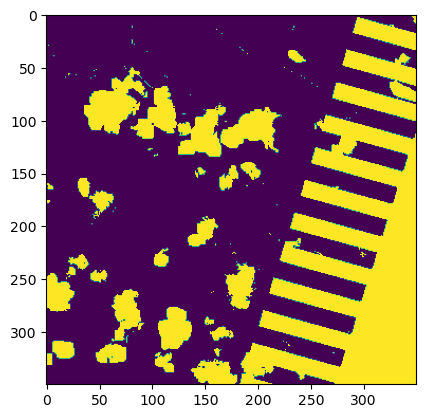

In [40]:
img = rasterio.open("data/train_satellite/ZV934951_satellite.tif").read()
plt.imshow(img[5])

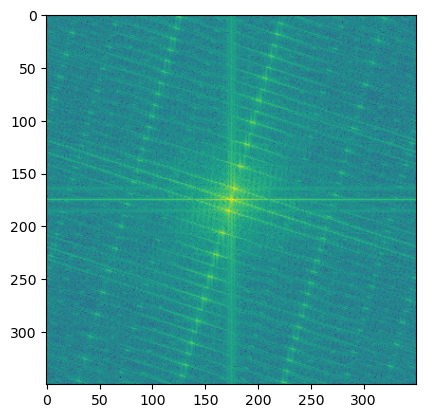

In [41]:
ft = np.fft.ifftshift(img[4])
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.imshow(np.log(abs(ft)))

In [42]:
def inpaint_img(img):
    # NaN mask
    img_nan = ((img[0] < 0) * 255).astype(np.uint8)  # required by opencv

    # Iterate all channels except DEM to fill NaN
    for i in [0, 1, 2, 3, 4, 5]:
        ch = img[i]
        ch = np.where(ch < 0, 0, ch)
        ch = ch.astype(np.uint16)  # required by opencv
        img[i] = cv2.inpaint(ch, img_nan, 3, cv2.INPAINT_NS)
        
    return img

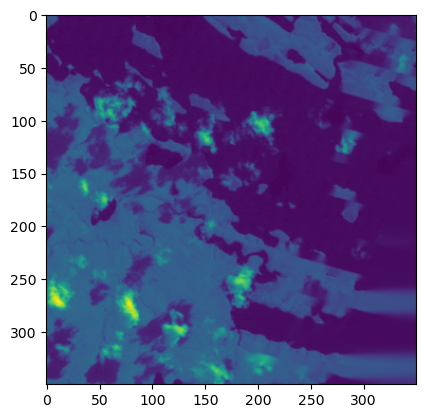

In [43]:
img = rasterio.open("data/train_satellite/ZV934951_satellite.tif").read()
img = inpaint_img(img)
plt.imshow(img[0])

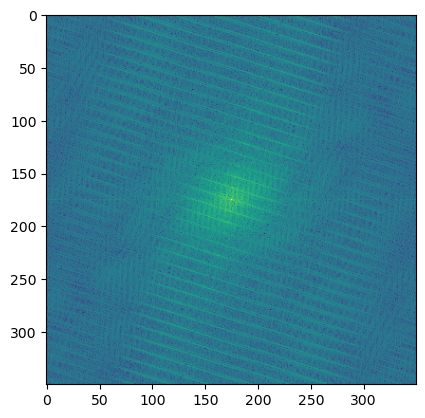

In [44]:
ft = np.fft.ifftshift(img[4])
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.imshow(np.log(abs(ft)))

In [58]:
root_orig = pathlib.Path("data")
root_inpainted = pathlib.Path("data_inpainted")
base = "test_satellite"

assert (root_orig / base).exists()
assert (root_inpainted / base).exists()

img_list = ["data/train_satellite/ZV934951_satellite.tif"]
img_list = (root_orig / base).glob("*.tif")

for fpath in tqdm.tqdm(img_list):
    fpath = pathlib.Path(fpath)

    # Load and fill NaN
    r = rasterio.open(fpath)
    img = r.read()
    img = inpaint_img(img)

    # Write back
    with rasterio.open(root_inpainted / base / fpath.name, "w", **r.profile) as dst:
        dst.write(img)

1426it [01:18, 18.12it/s]


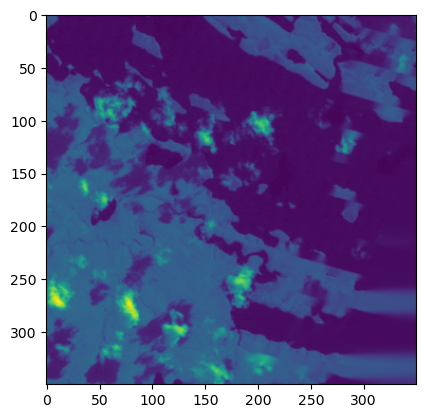

In [55]:
img = rasterio.open("data_inpainted/train_satellite/ZV934951_satellite.tif").read()
plt.imshow(img[0])